In [2]:
import scvelo as scv

In [3]:
adata = scv.read("MacrophagesFiltered-EF_Low_velo.h5ad")
adata

AnnData object with n_obs × n_vars = 6053 × 31053
    obs: 'orig.ident', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_ambiguous', 'nFeature_ambiguous', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.6', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters'
    var: 'features', 'ambiguous_features', 'spliced_features', 'unspliced_features'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [4]:
scv.pp.filter_and_normalize(adata, min_shared_counts = 20, n_top_genes = 2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 26370 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode = 'dynamical')
scv.tl.velocity_graph(adata)

recovering dynamics
    finished (0:04:07) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [6]:
clu_colors = ["#F8766D","#DB8E00","#AEA200","#64B200","#00BD5C","#00C1A7","#00BADE",
              "#00A6FF","#B385FF","#EF67EB","#FF63B6"]
adata.obs['clusters'] = adata.obs['RNA_snn_res.0.6']

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


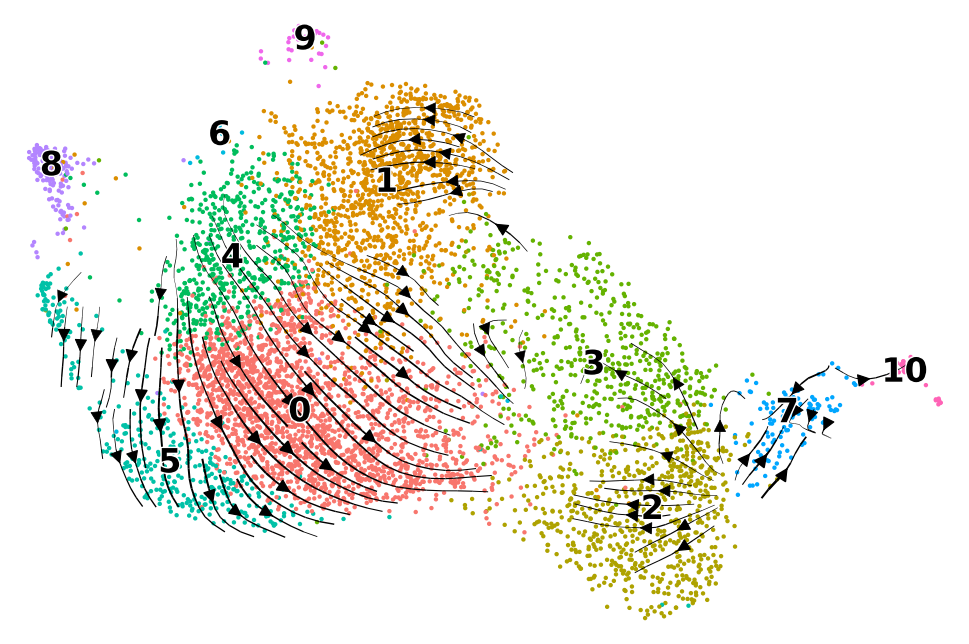

In [7]:
scv.pl.velocity_embedding_stream(adata, basis = 'umap', legend_fontsize = 12, title = '',
                                 color = "clusters", palette = clu_colors,
                                 dpi = 200, alpha = 1, size = 10, linewidth = 0.5, smooth = 0.5, min_mass = 3.8)

In [8]:
scv.tl.rank_velocity_genes(adata, groupby='clusters', min_corr=.3)
df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head(10)

ranking velocity genes
    finished (0:00:03) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


0        1        2        3        4        5              6  \
0  Tnfaip6     Ighm   Ifi205    Ms4a7  Herpud1     Actb           Sod2   
1     Il1b   Gpr141      F10     Lgmn    Ifi35    Prdx5          Rsad2   
2     Rgcc  S100a11     Lgmn    Kcnn4    Adam8     Rgcc          Rab7b   
3   Metrnl  Fam162a    Ms4a7     Gclm    Icam1  Tax1bp1  2310022A10Rik   
4     Il1a     Cd44    Acsl1    Acsl1   Lgals1     Sod2           Cd83   
5    Ifi35  Bcl2a1d    Kcnn4  Trim30a      Esd  Bcl2a1d          Snx20   
6   Slc7a2     Sod2    Sp140   Ifi205   Fam49b    Tnip3         Lsmem1   
7     Arg2    Oasl2     Gclm     Mdm2    Alas1    Fcgr1          Ifi35   
8    Adam8     Bst1  Trim30a    Oasl2  Smpdl3b       C3        Slc16a6   
9  Tax1bp1      Gda    Plbd1     Bst1     Smox     Mdm2         Gpr132   

         7       8         9      10  
0    Furin    Actb   S100a11   C3ar1  
1      F10      C3     Itga5   Rsad2  
2     Actb     Mt1    Gpr141      C3  
3     Pkib   Rsad2    Pou2f2   Oasl2  
4     Lgmn   P2ry6      Ighm  Clec9a  
5     Slpi  Arrdc4   Bcl2a1d   Cebpg  
6    Sp140   Thbs1     Cytip   Alas1  
7     Ighm   Furin      Arg1  Ifi205  
8  Plekho1    Ighm  Arhgap30     Esd  
9  Trim30a   Cebpg     Cflar    Ighm

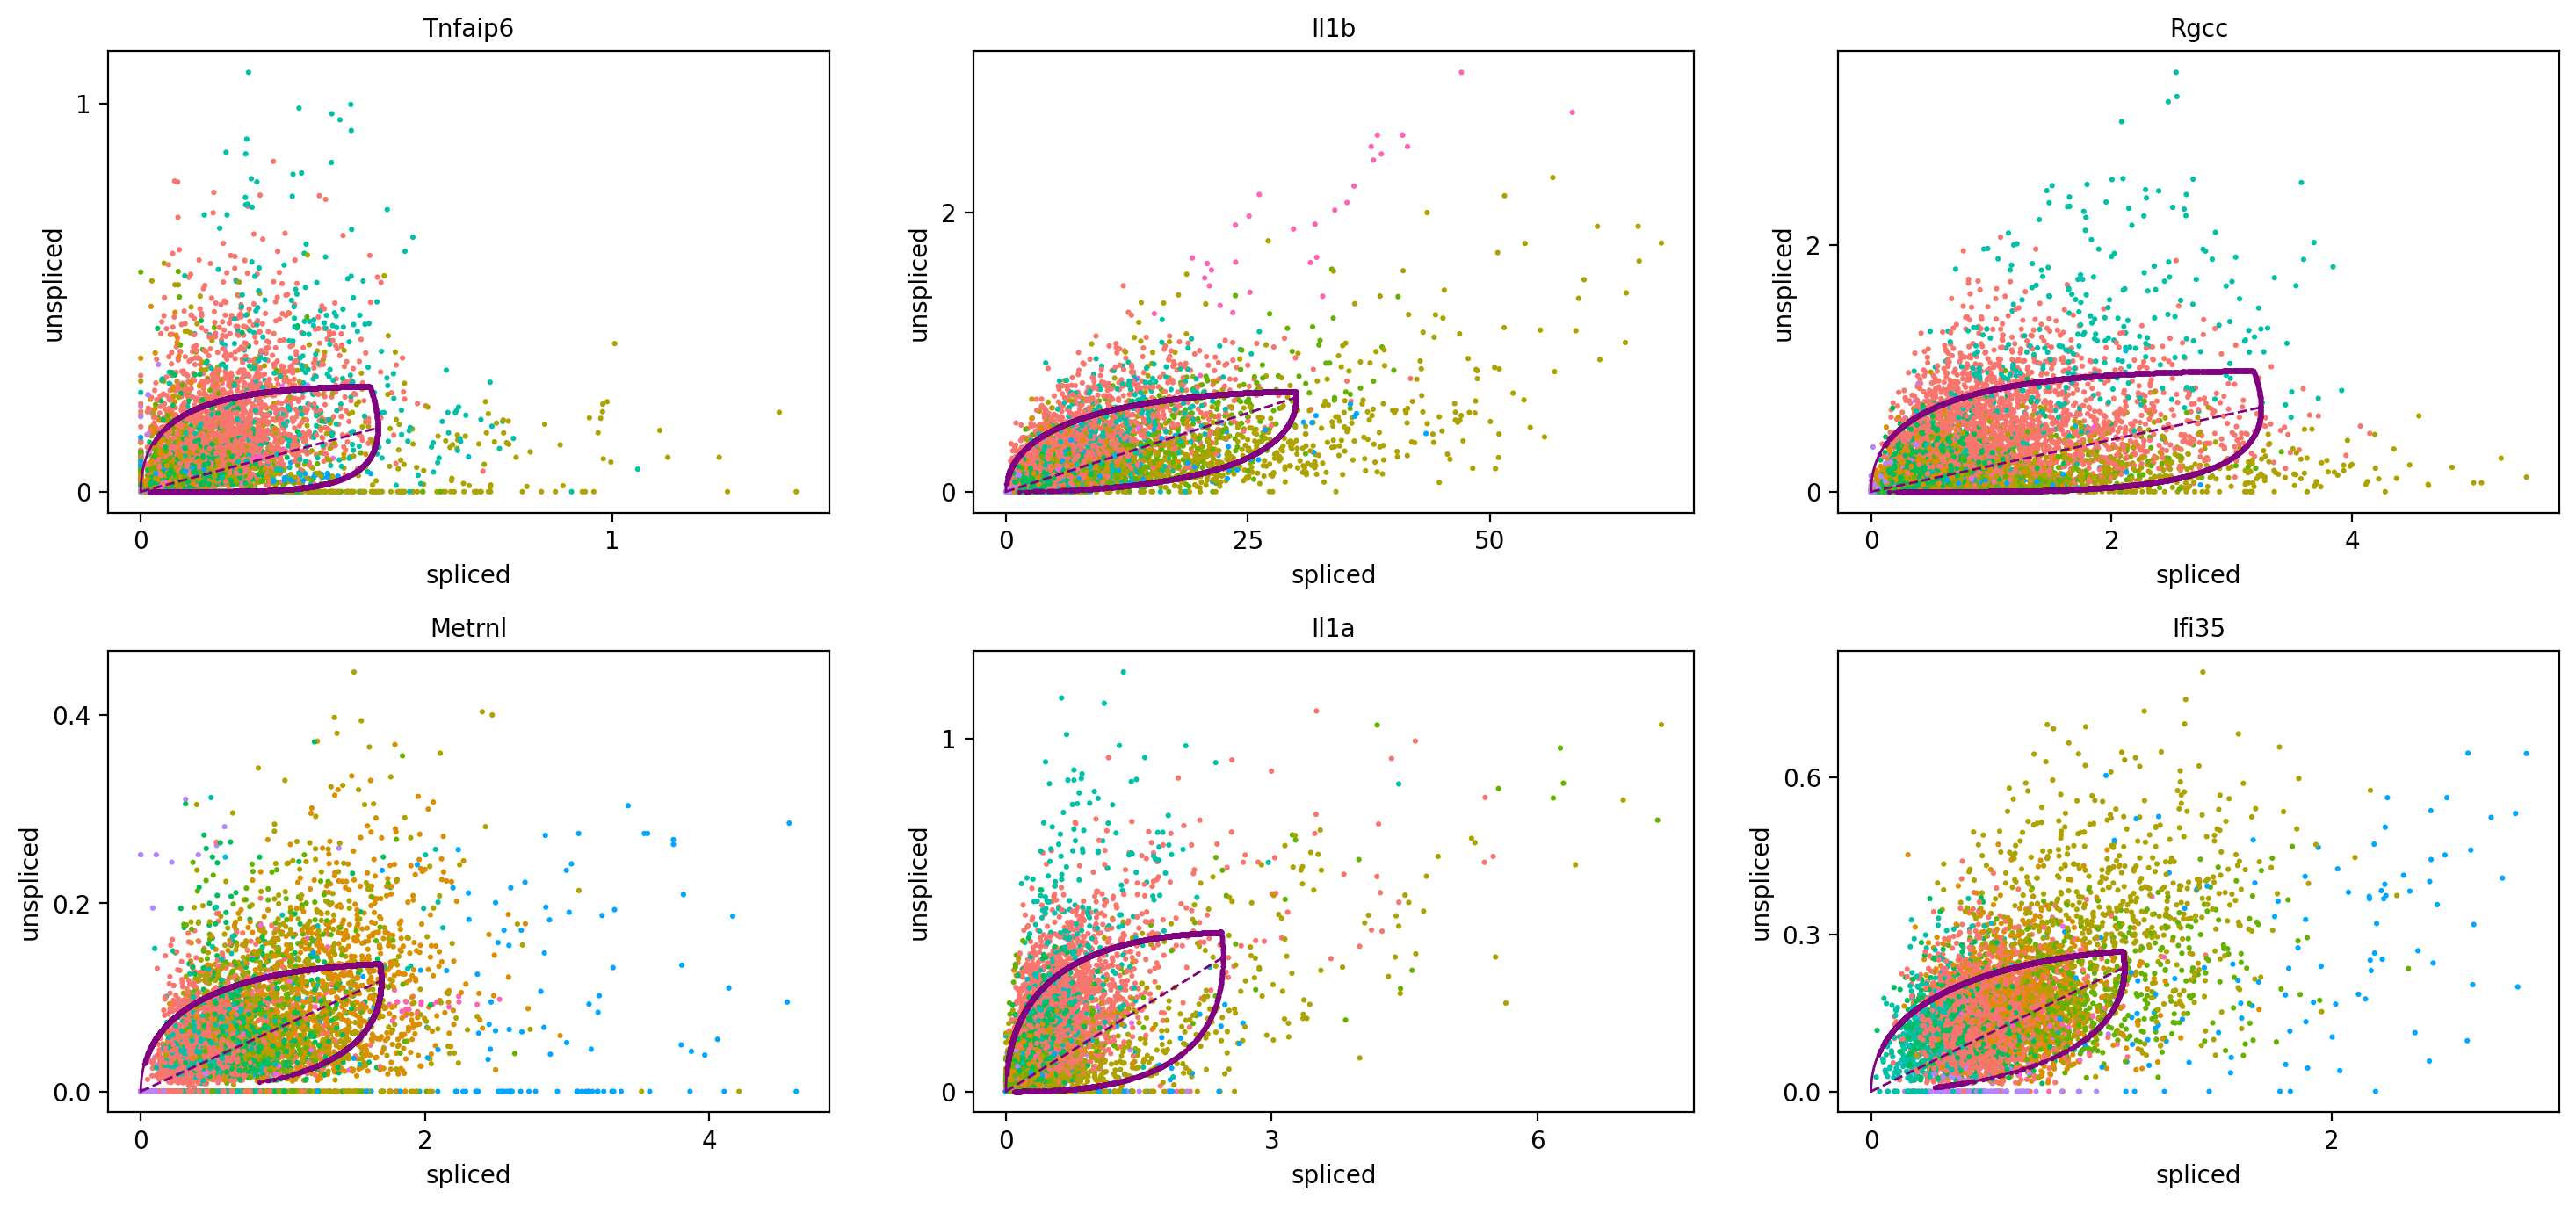

In [9]:
scv.pl.scatter(adata, df['0'][:6], ncols = 3, palette = clu_colors, dpi= 200)

# Velocity Confidence & Pseudotime

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


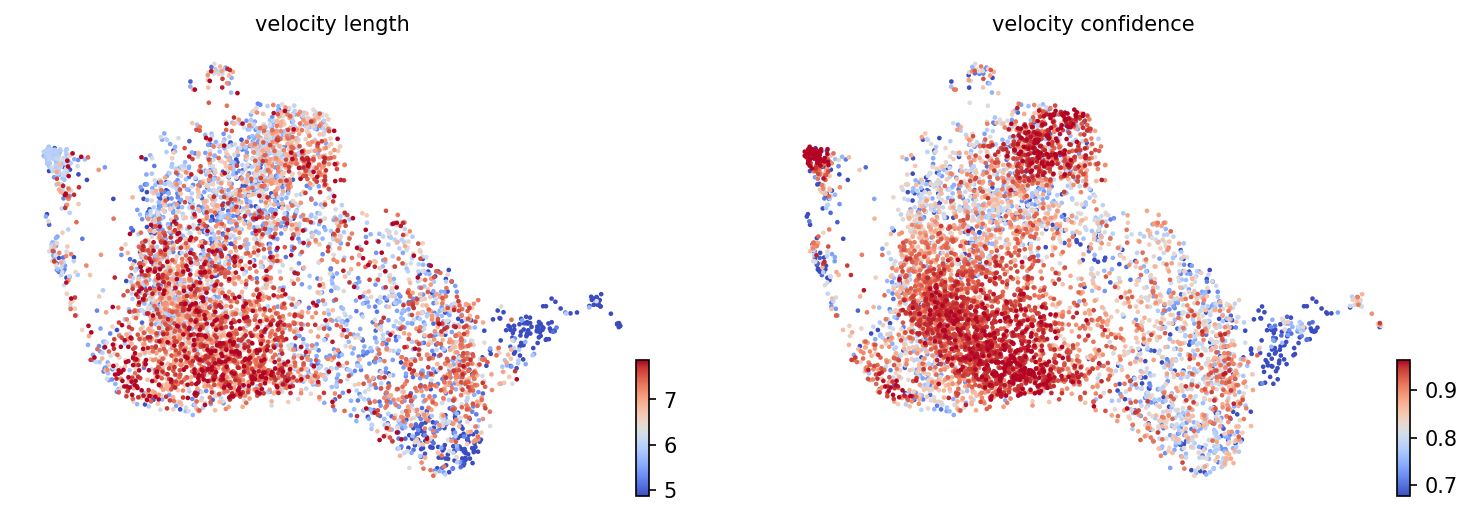

In [13]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95], dpi = 150)

In [14]:
df = adata.obs.groupby('clusters')[keys].mean().T
df.style.background_gradient(cmap='coolwarm', axis=1)

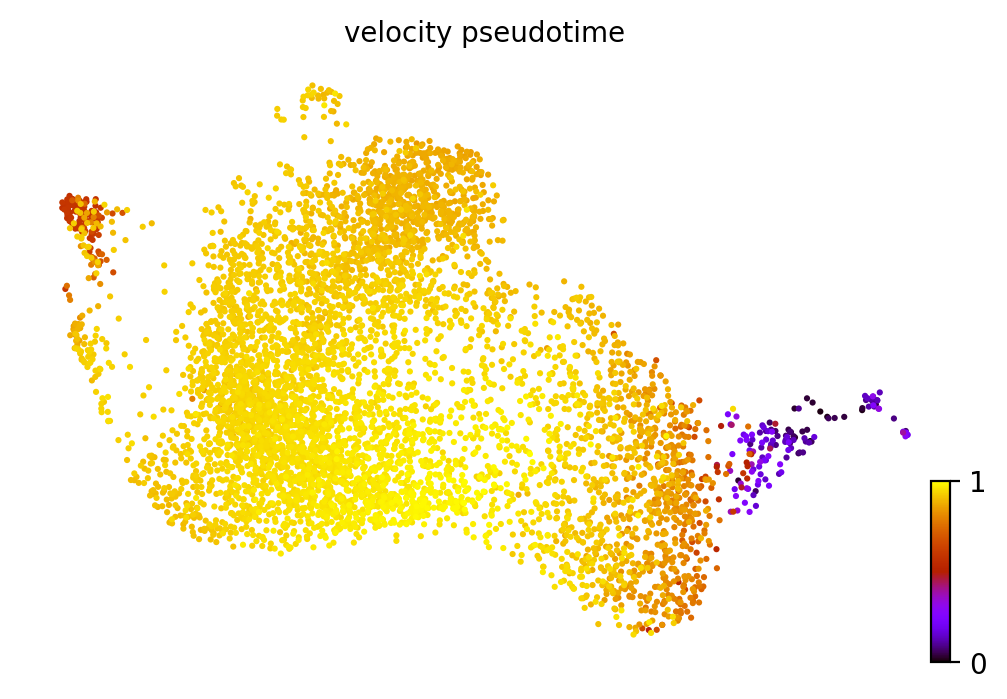

In [15]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot', dpi = 200)

# PAGA velocity graph

In [16]:
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

In [17]:
scv.tl.paga(adata, groups='clusters')
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:02) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


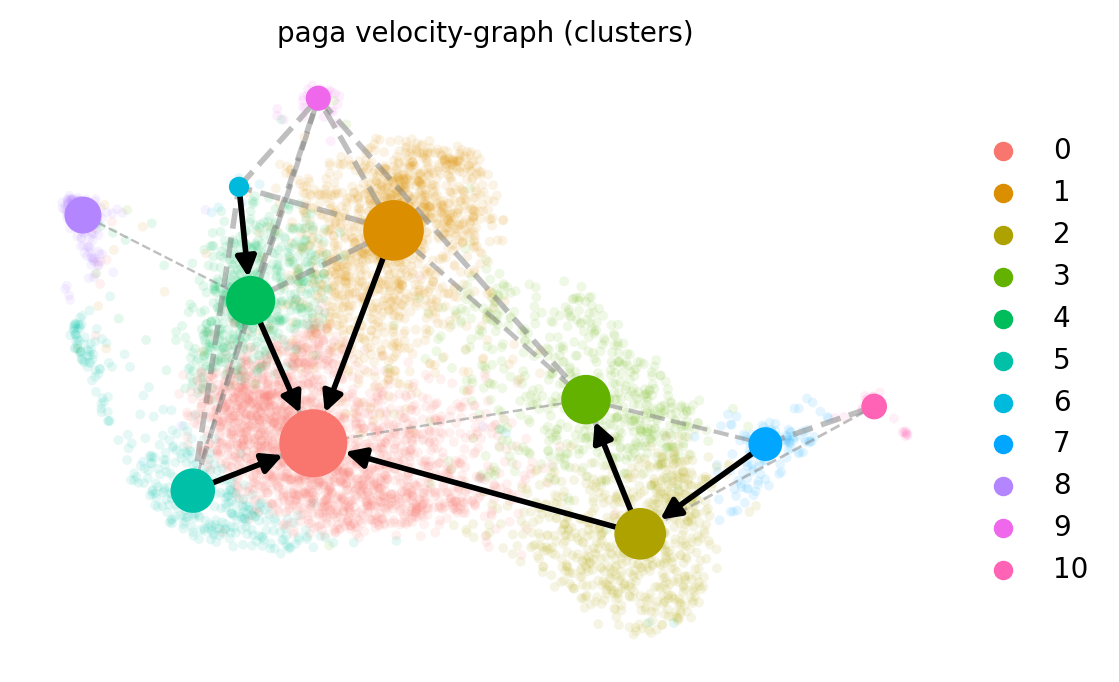

In [34]:
scv.pl.paga(adata, basis='umap', size=50, alpha=.1, threshold=0.2,
            min_edge_width=2, node_size_scale=1.5, dpi = 200, layout = 'fa')

# End